# MYTHBUSTERS - GOLF STATISTICS EDITION
##Nicholas Jones and Rohan Bhagat
###*For Professor Ronnie Howard's CS2316 Class*


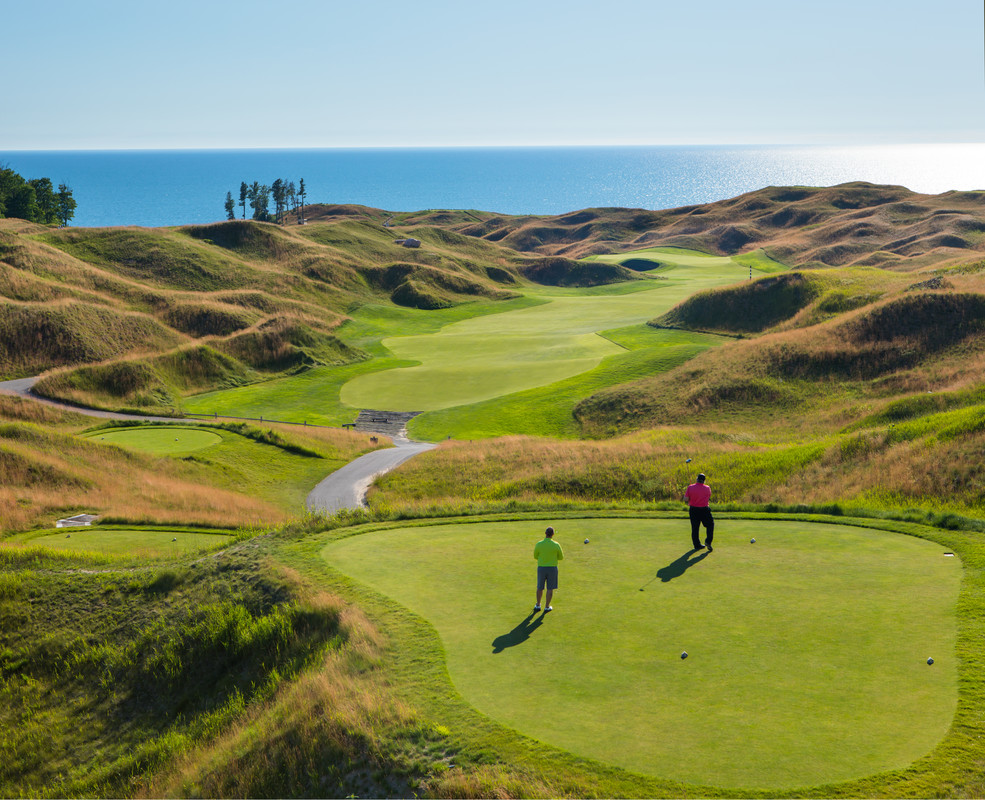

**Golf** is one of the most popular recreational sports in the world, enjoyed from Japan, to the United States, to South Africa. It is estimated over 60 million people play golf, with over 450 million fans around the globe.

It comes from humble beginnings, on windswept Scottish moors played with hickory and goosefeathers. It was only 100 years ago that the grandfather of modern golf, Bobby Jones, won his first major at the 1923 U.S. Open. Now, you'd struggle to find someone who hasn't heard the name "Tiger Woods." Presidents, athletes, and celebrities play golf. Billions of dollars of commerce are conducted over golf outings.

As with all modern sports, as it's popularity has grown, so has the energy and time invested into being "better," at all levels. Pro's spend thousands of dollars a week on teams of swing coaches, physical therapists, and nutritionists to eek every ounce of performance out of their bodies. Amateurs are constantly marketed the next swing training aid, or open up YouTube to a flood of videos suggesting "This" will fix their swing.

With that, over the last 10 years, significantly more attention has been paid to statistics on the golf course. "Strokes Gained" was invented as a way to compare elements of a player's game against the field. Percentages for things like Greens in Regulation or Fairways, and "length" off the tee, are becoming more and more important.

This came to a peak in 2020. Bryson DeChambeau, a golf "nerd," more fixated on obsessing over his driver launch angle and distance than actually playing a round, accomplished a historic feat. He "overpowered" Winged Foot, driving the ball an average of 325 yards and separating from the field entirely.

Now, it's at the point even "hackers" track their shots with fancy accessories attached to their clubs. Everyone seems to know the betting odds they have on every shot on the course. Age old adages like "Drive for show, putt for dough" are being replaced by dudes arguing about optimal spin rates off the tee.

We, as golf players and fans ourselves, wish to examine for ourselves which golf statistics play the most important role in being a high level professional, or amateur, golfer. We got our hands on a giant spreadsheet with thousands of statistics on tour players from the last ~8 seasons, and we're going to try and examine if all the statistics talk nowadays is scratch, or just a bogey-golfer trying to play blades.




# Data Collection and Cleaning

Firstly, we had to clean up our CSV file. Our file had a ton of extraneous information (like insurance companies sponsoring tournaments), NaN values, and other stuff we didn't want. We also had to handle things like "CUT" and "W/D" being put into the "finish" column with all the finish numbers. Once we had our CSV cleaned, it was roughly 26 columns by 34000 rows, and we saved that to a new CSV file.

We also wanted some additional data to compare it against. We webscraped three webpages to find the average putts per round, average drive distance, and total money earnings for each player on the PGA Tour during the 2022-23 season so far. We then saved that information to another CSV file under a dict sorted by player name.

Lastly, we wanted to access the sportsdata API to pull information about each golfer's average odds to win the 2022 Masters and then access our cleaned CSV and pair these odds with their actual putting and driving performances in the tournament. We returned this information as a dictionary pairing odds to strokes gained putting and strokes gained off the tee, and then wrote this information to a JSON file.

## Downloaded Dataset Requirement



In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import requests
import io
from pprint import pprint
import json
from scipy import stats
from sklearn.linear_model import LinearRegression


def data_parser():
  csvURL = 'https://raw.githubusercontent.com/rbhagat9/cs2316project/main/ASA%20All%20PGA%20Raw%20Data%20-%20Tourn%20Level.csv'
  df = pd.read_csv(csvURL)
  #df.head()
  #df.shape

  # store course information in dictionary outside df ['tournament id', 'purse']
  # tournament_id_dict = {row[0] : (row[1], row[2], row[3], row[4]) for row in zip(df['tournament id'], df['tournament name'], df['course'], df['season'], df['date'])}
  # print(tournament_id_dict)

  # consolidate strokes and hole par data into one column for score
  df['strokes'] -= df['hole_par']
  df.rename({'strokes' : 'performance'}, axis='columns')

  # eliminate unnecessary columns
  to_drop = ['Player_initial_last', 'player id', 'course', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'n_rounds', 'hole_par', 'no_cut', 'made_cut']
  # print(df.shape)
  df.drop(columns=to_drop, inplace=True)
  # print(df.shape)

  # drop rows containing nas in columns other than position
  toCheck = list(df.columns.values)
  # print(len(toCheck))
  toCheck.remove('pos')
  # print(len(toCheck))
  df.dropna(axis=0, subset=toCheck, inplace=True)
  # print(df.shape)

  # drop rows containing nas in position if they didn't finish as cut
  madeCut = df[(df['Finish'] != 'CUT') & df['pos'].isna()].index
  df.drop(madeCut, inplace=True)
  # print(df.shape)

  # combine data in Finish and position columns so that we extract only int data if the golfer placed
  # Then drop Finish and position columns as they are no longer needed
  newCol = pd.Series([row[1] if row[0][-1].isdigit() else row[0] for row in zip(df['Finish'], df['pos'])])
  #print(newCol.shape)
  newCol = newCol.apply(lambda x : 105 if x in ['W/D', 'WD', 'CUT'] else x)
  #print(newCol.shape)
  #print(df.shape)
  df = pd.concat([df.reset_index(), newCol.reset_index()], axis = 1)
  #print(df.shape)
  df.rename(columns={0: 'finish'}, inplace=True)

  df.drop('pos', inplace=True, axis=1)
  df.drop('Finish', inplace=True, axis=1)
  df.drop('index', inplace=True, axis=1)

  df.to_csv('cleanedCSV.csv', index=False)
  #print(list(df.columns))

  return df




############ Function Call ############
print(data_parser())

       tournament id  strokes  hole_DKP  hole_FDP  hole_SDP  streak_DKP  \
0          401353224        1      60.0      51.1        56           3   
1          401353224       -2      72.5      61.5        61           8   
2          401353224        3      21.5      17.4        27           0   
3          401353224        7      20.5      13.6        17           0   
4          401353224        4      23.5      18.1        23           0   
...              ...      ...       ...       ...       ...         ...   
28387           2260       -9      70.5      68.2        73           0   
28388           2260       -8      72.0      66.8        72           6   
28389           2260      -15      86.5      84.0        81          14   
28390           2260       -2      29.0      27.6        34           0   
28391           2260        0      27.5      24.1        31           3   

       streak_FDP  streak_SDP  finish_DKP  finish_FDP  ...        date  purse  \
0             7.6 

## Web Collection Requirement \#1


In [4]:
def web_parser1():
  # scraping data on this year's pga tour from cbs sports website
  puttingURL = 'https://www.cbssports.com/golf/stats/pga-tour/putt-per-round/'
  drivingURL = 'https://www.cbssports.com/golf/stats/pga-tour/drive-distance/'
  pointsURL = 'https://www.cbssports.com/golf/stats/pga-tour/pga-championship-points/'

  # store data in dictionary and write to csv
  totalData = {}

  # collecting putting data
  puttingPage = requests.get(puttingURL)
  #puttingPage = urllib.request.urlopen(puttingURL).read().decode('utf-8')
  soup = BeautifulSoup(puttingPage.content, 'html.parser')
  players = soup.find("table").find('tbody').find_all('tr')
  #print(len(players))

  for player in players:
    data = player.find_all('td')
    #rint(len(data))
    playerName = data[2].find_all('span')[2]
    playerName = playerName.find('a').text
    averagePuttsPerRound = float(data[3].text.strip())
    #print(playerName)
    totalData[playerName] = [averagePuttsPerRound]

  # collecting driving data
  drivingPage = requests.get(drivingURL)
  soup = BeautifulSoup(drivingPage.content, 'html.parser')
  players = soup.find("table").find('tbody').find_all('tr')
  #print(len(players))

  for player in players:
    data = player.find_all('td')
    #print(len(data))
    playerName = data[2].find_all('span')[2]
    playerName = playerName.find('a').text
    averageDrivingDistance = float(data[3].text.strip())
    #print(playerName)
    try:
      totalData[playerName].append(averageDrivingDistance)
    except:
      continue # do not care about data if we don't have a complete set of putting data, driving data, and earnings

  # collecting pga tour championship points
  pointsPage = requests.get(pointsURL)
  soup = BeautifulSoup(pointsPage.content, 'html.parser')
  players = soup.find("table").find('tbody').find_all('tr')
  #print(len(players))

  for player in players:
    data = player.find_all('td')
    #rint(len(data))
    playerName = data[2].find_all('span')[2]
    playerName = playerName.find('a').text
    totalPoints = float(data[3].text.strip().replace(',', ''))
    #print(playerName)
    try:
      totalData[playerName].append(totalPoints)
    except:
      continue # do not care about data if we don't have a complete set of putting data, driving data, and earnings

  # remove elements of finalData that contain incomplete data
  finalData = {player : values for player, values in totalData.items() if len(values) == 3}
  #print(len(finalData))

  # write dictionary to new file
  with open('cbsData.csv', 'w') as f:
    f.write('#, Player Name, Average Putts Per Round, Average Driving Distance, Total PGA Tour Championship Points\n')
    number = 1
    for player in finalData:
      f.write(f'{number}, {player}, {finalData[player][0]}, {finalData[player][1]}, {finalData[player][2]}\n')
      number += 1
  return finalData





############ Function Call ############
print(web_parser1())

{'Taylor Montgomery': [27.256, 304.3, 2541522.0], 'Eric Cole': [27.644, 297.5, 2887527.0], 'Maverick McNealy': [27.649, 300.7, 1995176.0], 'Sam Ryder': [27.827, 293.2, 2148040.0], 'Peter Malnati': [27.845, 295.2, 1639444.0], 'Byeong Hun An': [27.925, 315.6, 2379360.0], 'Min Woo Lee': [27.95, 313.5, 2784382.0], 'Aaron Baddeley': [27.969, 282.4, 1050486.0], 'Harry Higgs': [27.984, 302.6, 838925.0], 'Tommy Fleetwood': [28.032, 302.2, 6803020.0], 'Brendon Todd': [28.025, 283.0, 3967820.0], 'Sahith Theegala': [28.047, 303.4, 6841639.0], 'S.H. Kim': [28.075, 307.2, 1473068.0], 'Sam Burns': [28.108, 310.9, 9268404.0], 'Jason Day': [28.162, 303.7, 7070594.0], 'Nick Taylor': [28.164, 292.7, 5899290.0], 'Aaron Wise': [28.163, 301.5, 3125059.0], 'Max Homa': [28.171, 302.8, 10287413.0], 'Thomas Detry': [28.182, 307.1, 2465631.0], 'Justin Lower': [28.198, 293.3, 1536032.0], 'Beau Hossler': [28.213, 305.1, 2414713.0], 'David Lingmerth': [28.23, 278.0, 2318757.0], 'Justin Rose': [28.25, 294.9, 492818

## Helper Method for Web Collection Requirement #2



In [5]:
"""
Helper method to retrieve api data
On first use, caches data retrieved from api in a different file to prevent unnecessary additional calls to API
For further uses, retrieves data from cache
"""
def getData(*, overwriteFile: bool = False, cacheLocation: str, URL: str, APIKey: str):
  if overwriteFile:
      jsonData = None
  else:
    try:
      with open(cacheLocation, 'r') as f:
        jsonData = json.load(f)
        print('Data retrieved successfully.')
    except(FileNotFoundError, json.JSONDecodeError) as e:
      print(f'Error -> {e}')
      jsonData = None
  if not jsonData:
    print('No local cache exists. Retrieving data.')
    jsonData = requests.get(URL+APIKey).json()
    with open(cacheLocation, 'w') as cache:
      json.dump(jsonData, cache)
      print('Data dumped to file.')
  return jsonData

## Web Collection Requirement #2

In [6]:
def web_parser2():
   # using sportsdata api
  # for the last full season, use endpoint for each tournament (careful with making calls/testing code bc we're limited to 1000 calls per month)
  # finding list of tournament ids in the 2021-22 pga tour season using schedule by season endpoint
  tournamentBaseURL = 'https://api.sportsdata.io/golf/v2/json/Tournaments/2022?key='
  key = '976cb5f8bb6f406b81d7539d1b2db1b9'
  tournamentData: dict = getData(overwriteFile=False, cacheLocation='masters2022ID.json', URL=tournamentBaseURL, APIKey=key)
  #pprint(tournamentData)
  for tournament in tournamentData:
    if tournament['Name'] == 'Masters Tournament':
      masters2022TournamentID = str(tournament['TournamentID'])

  # then pull the odds for each player in the tournament to win
  player_odds = {}
  # call api using betting markets by tournament id endpoint
  bettingBaseURL = f'https://api.sportsdata.io/v3/golf/odds/json/BettingMarketsByTournamentID/{masters2022TournamentID}?key='
  bettingData: dict = getData(overwriteFile=False, cacheLocation='betting.json', URL=bettingBaseURL, APIKey=key)
  # pprint(bettingData)

  # go to csv file and pull those players' strokes gained off the tee and strokes gained putting and store as a tuple in dictionary

  df = pd.read_csv('cleanedCSV.csv', low_memory=False)
  playerResultsDict = {row[0] : (row[1], row[2]) for row in zip(df['player'], df['sg_putt'], df['sg_ott'], df['tournament name'], df['season']) if row[3] == 'Masters Tournament' and row[4] == 2022}

  # iterate through betting data for players in playerResutlsDict
  playerOddsDict = {}
  for i in range(len(bettingData)):
    for aDict in bettingData[i]['BettingOutcomes']:
      if aDict['Participant'] in playerResultsDict and not aDict['IsInPlayTournamentOdd'] and aDict['PayoutAmerican'] > 1500:
        try:
          playerOddsDict[aDict['Participant']].append(aDict['PayoutAmerican'])
        except:
          playerOddsDict[aDict['Participant']] = [aDict['PayoutAmerican']]
  for player, odds in playerOddsDict.items():
    playerOddsDict[player] = sum(odds)//len(odds)

  # store resulting data in odds dictionary with odds as keys and strokes gained tuples as values
  oddsSGDict = {}
  for player, averageOdds in playerOddsDict.items():
    try:
      oddsSGDict[averageOdds].append(playerResultsDict[player])
    except:
      oddsSGDict[averageOdds] = [playerResultsDict[player]]
  # pprint(oddsSGDict)
  # print(len(oddsSGDict))
  # write dictionary to json
  with open('odds.json', 'w') as odds:
    json.dump(oddsSGDict, odds)
  return oddsSGDict





############ Function Call ############
print(web_parser2())

Error -> [Errno 2] No such file or directory: 'masters2022ID.json'
No local cache exists. Retrieving data.
Data dumped to file.
Error -> [Errno 2] No such file or directory: 'betting.json'
No local cache exists. Retrieving data.
Data dumped to file.
{26275: [(-2.52, -0.85)], 27008: [(-1.22, 0.06)], 4989: [(-0.09, 1.18)], 13754: [(-0.22, -0.62)], 12366: [(-1.42, 0.12)], 7544: [(0.31, -2.01)], 4654: [(1.4, 0.55)], 28442: [(-0.74, -1.36)], 4052: [(-0.65, 0.13)], 26919: [(1.52, -3.16)], 9841: [(-1.42, -0.01)], 29713: [(-0.5, 0.03)], 30267: [(-1.07, -1.1)], 10035: [(-1.24, 0.05)], 11223: [(-0.94, 0.17)], 14682: [(0.17, 0.07)], 7104: [(1.41, -0.1)], 8951: [(1.67, -0.28)], 6274: [(0.23, 0.6)], 4945: [(0.12, -0.12)], 12212: [(1.4, -1.74)], 6904: [(-1.33, -1.67)], 6804: [(2.72, 0.25)], 5223: [(0.96, 0.44)], 11170: [(1.36, -0.98)], 4578: [(0.07, 0.27)], 12814: [(0.7, -0.38)], 6815: [(-0.01, 0.39)], 5815: [(-0.88, -0.13)], 6234: [(-1.37, -0.51)], 7164: [(0.49, 1.04)], 7211: [(-0.17, -0.14)], 1524

## Data Sources

*   Downloaded Dataset Source: 'https://raw.githubusercontent.com/rbhagat9/cs2316project/main/ASA%20All%20PGA%20Raw%20Data%20-%20Tourn%20Level.csv

*   Web Collection #1 Source(s):
*   1. 'https://www.cbssports.com/golf/stats/pga-tour/putt-per-round/'
*   2. 'https://www.cbssports.com/golf/stats/pga-tour/drive-distance/'
*   3. 'https://www.cbssports.com/golf/stats/pga-tour/pga-championship-points/'

*   Web Collection #2 Source:   https://api.sportsdata.io/golf/v2/json/Tournaments/2022?key=976cb5f8bb6f406b81d7539d1b2db1b9

# Data Analysis Requirements

*   Create at least 5 insights
*   Generate at least 3 data visualizations
*   Export aggregated data to at least 1 summary file




#Data Analysis Description

1. Visualization 1 - The first, burning question we have is simple: is driving or putting more important to tournament finish? We're going to compare strokes gained off the tee to strokes gained putting, and see which has a stronger correlation with tournament finish.

2. Visualization 2 - Okay, we've established that putting seems to have a higher correlation with tournament finish. Hm... that goes against the "modern" wisdom. Let's test it in a different way.

3. Okay, now that we've double checked that data, it seems to point to the fact that being a better putter is more correlated to your finish. However, let's test it in a slightly different way. Let's group players into the category of "driver" or "putter" based on which category is higher for strokes gained, and then compare that to their FanDuel Points (betting odds).

4. Now let's use our webscraped data. Let's check if players are above or below the mean as putters based on putts per round. Then let's check if they're above or below the mean as drivers based on driving distance. Then let's rank them as "driver" or "putter" and compare it against their championship points.

5. Visualization 3 - Let's see if we can isolate for some extremes. There is some theory that you need a minimum amount of strokes gained off the tee to compete, but that once you're in the ballpark with the bigboys, putting is what makes a difference. So let's compare the top and bottom 10% in the categories of putting and driving.

6. Here we look at the relationship between sg_ott and sg_putt.

7. Visualization 4 - We visualize the relationship between sg_ott and sg_putt after selected for players that finished in the top 20.



## Insights

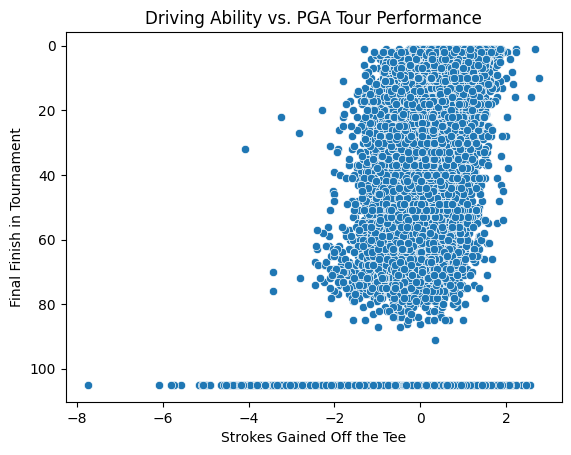

Driving Influence
Coefficient of determination: 0.10248447826105589
Intercept: [63.87097056]
Slope: [[-15.53979663]]
Pearson's Coefficient Data: PearsonRResult(statistic=-0.3201319700702443, pvalue=0.0)


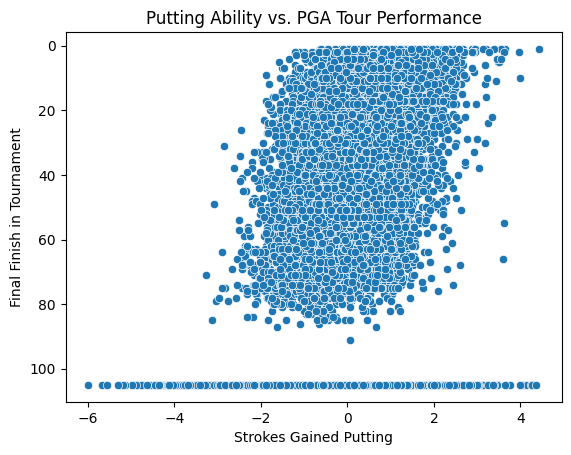

Putting Influence
Coefficient of determination: 0.2007286878099349
Intercept: [62.66646544]
Slope: [[-15.63870467]]
Pearson's Coefficient Data: PearsonRResult(statistic=-0.4491008318118401, pvalue=0.0)


In [7]:
def insight1():
  df = data_parser()
  ## compare driving ability to performance w/graph
  driving = sns.scatterplot(x="sg_ott", y="finish", data=df);
  driving.set_title("Driving Ability vs. PGA Tour Performance")
  driving.set_xlabel("Strokes Gained Off the Tee");
  driving.set_ylabel("Final Finish in Tournament")
  driving.invert_yaxis()
  # UNIQUE VISUALIZATION 1
  plt.show()

  ## correlation data for driving-performance
  x = np.array(df['sg_ott']).reshape(-1,1)
  y = np.array(df['finish']).reshape(-1,1)

  model = LinearRegression().fit(x,y)
  r_sq = model.score(x, y)
  print('Driving Influence')
  print(f'Coefficient of determination: {r_sq}')
  print(f'Intercept: {model.intercept_}')
  print(f'Slope: {model.coef_}')
  print(f"Pearson's Coefficient Data: {stats.pearsonr(df['sg_ott'], df['finish'])}")

  ## compare putting ability to performance w/graph
  putting = sns.scatterplot(x="sg_putt", y="finish", data=df);
  putting.set_title("Putting Ability vs. PGA Tour Performance")
  putting.set_xlabel("Strokes Gained Putting");
  putting.set_ylabel("Final Finish in Tournament")
  putting.invert_yaxis()
  plt.show()

  ## correlation data for putting-performance
  x2 = np.array(df['sg_putt']).reshape(-1,1)
  y2 = np.array(df['finish']).reshape(-1,1)

  model2 = LinearRegression().fit(x2,y2)
  r_sq2 = model.score(x2, y2)
  print('Putting Influence')
  print(f'Coefficient of determination: {r_sq2}')
  print(f'Intercept: {model2.intercept_}')
  print(f'Slope: {model2.coef_}')
  print(f"Pearson's Coefficient Data: {stats.pearsonr(df['sg_putt'], df['finish'])}")

############ Function Call ############
insight1()

### Insight 1 Explanation

Interestingly enough, this data seems to show that putting's coefficition with finish (0.2) is higher than driver's coeffiction (0.1). It also seems to show that players seem to cap out at 2 strokes gained off the tee, with a handful maybe at 3. Players seem able to gain more strokes putting, with 4 on the upper range and 5 at maximum.

This data is visualized via a basic scatterpot showing the range of strokes gained and tournament finish. There are lots of dots along the bottom of the range, which are players who were cut or withdrew from the tournament. As can be expected, the more strokes gained you have in either category, the higher your tournament finish.

Correlation between 'sg_ott' and 'finish': -0.32013197007024385
Correlation between 'sg_putt' and 'finish': -0.44910083181183985
'sg_putt' is more correlated with 'finish'.


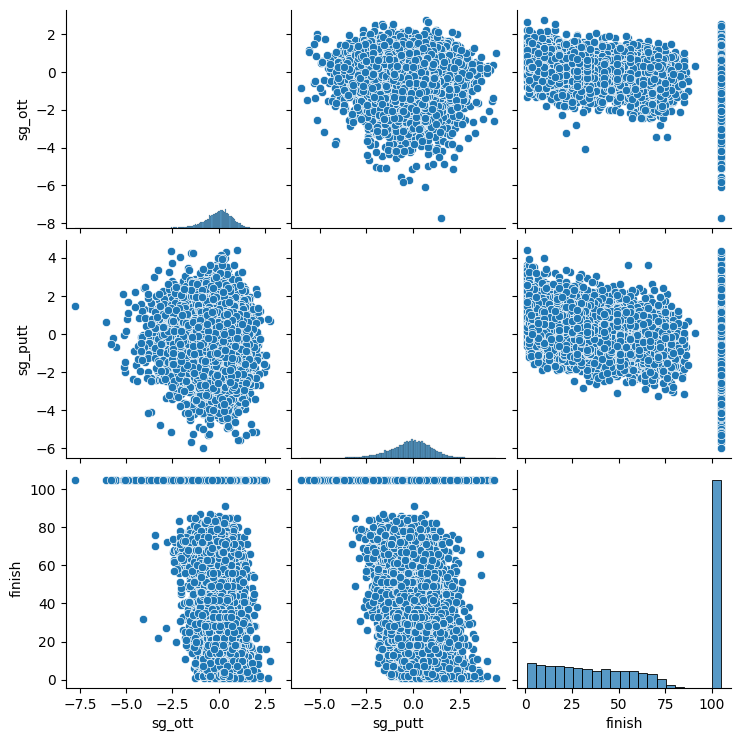

In [8]:
def insight2():

  df = data_parser()

  df_filtered = df[~df['finish'].isin(['CUT', 'W/D'])]
  df_filtered['finish'] = pd.to_numeric(df_filtered['finish'], errors='coerce')
  df_filtered.dropna(subset=['finish'], inplace=True)

  corr_sg_ott = df_filtered['sg_ott'].corr(df_filtered['finish'])
  corr_sg_putt = df_filtered['sg_putt'].corr(df_filtered['finish'])

  print("Correlation between 'sg_ott' and 'finish':", corr_sg_ott)
  print("Correlation between 'sg_putt' and 'finish':", corr_sg_putt)

  if abs(corr_sg_ott) > abs(corr_sg_putt):
    print("'sg_ott' is more correlated with 'finish'.")
  elif abs(corr_sg_putt) > abs(corr_sg_ott):
    print("'sg_putt' is more correlated with 'finish'.")
  else:
    print("Both 'sg_ott' and 'sg_putt' have the same correlation with 'finish'.")

  # UNIQUE VISUALIZATION 2
  sns.pairplot(df_filtered[['sg_ott', 'sg_putt', 'finish']])
  plt.show()



############ Function Call ############
insight2()

### Insight 2 Explanation

Here is a simple correlation comparison. It also states that putting is more correlated with finish. It is basically a restatement of the above using different code to reaffirm results, because this is a key finding.

Additionally, we use a pairplot to show the clusters of data and their extremes in separate, broken down ways.

In [9]:
def insight3():

  df = data_parser()

  grouped_df = df.groupby('player', as_index=False)['total_FDP'].sum()

  grouped_df['higher_strokes_gained'] = 'putter'
  grouped_df.loc[grouped_df['player'].isin(df.loc[df['sg_ott'] > df['sg_putt'], 'player']), 'higher_strokes_gained'] = 'driver'

  grouped_df = grouped_df.sort_values(by='total_FDP', ascending=False).reset_index(drop=True)

  print(grouped_df)



############ Function Call ############
insight3()

             player  total_FDP higher_strokes_gained
0     Justin Thomas    10524.9                driver
1        Tony Finau    10286.5                driver
2      Jason Kokrak     9802.5                driver
3     Jordan Spieth     9573.6                driver
4      Brian Harman     9558.5                driver
..              ...        ...                   ...
475  Craig Brischke       -6.4                driver
476   Sonny Skinner      -12.5                putter
477    Larkin Gross      -13.8                driver
478    Tyler Collet      -14.1                putter
479  Kamaiu Johnson      -18.2                driver

[480 rows x 3 columns]


In [10]:
def insight4():

    data_dict = web_parser1()
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Average Putts Per Round', 'Average Driving Distance', 'Total PGA Tour Championship Points'])

    avg_driving_distance = df['Average Driving Distance'].mean()
    avg_putts_per_round = df['Average Putts Per Round'].mean()

    df['variation_driving_distance'] = (df['Average Driving Distance'] - avg_driving_distance) / avg_driving_distance
    df['variation_putts_per_round'] = -1 * ((df['Average Putts Per Round'] - avg_putts_per_round) / avg_putts_per_round)

    df['tag'] = 'putter'
    df.loc[(df['variation_putts_per_round']) < (df['variation_driving_distance']), 'tag'] = 'driver'
    df.loc[(df['variation_putts_per_round']) == (df['variation_driving_distance']), 'tag'] = 'mixed'

    df = df.sort_values(by='Total PGA Tour Championship Points', ascending=False)
    df['rank'] = range(1, len(df) + 1)

    pd.set_option('display.float_format', '{:.2f}'.format)
    return df[['rank', 'tag', 'Total PGA Tour Championship Points', 'variation_driving_distance', 'variation_putts_per_round']]


###CALL###
insight4()


,rank,tag,Total PGA Tour Championship Points,variation_driving_distance,variation_putts_per_round
Scottie Scheffler,1,driver,23047190.00,0.03,-0.01
Jon Rahm,2,driver,17969998.00,0.05,0.01
Rory McIlroy,3,driver,16050463.00,0.09,0.01
Patrick Cantlay,4,driver,13047542.00,0.03,0.01
Xander Schauffele,5,putter,12582905.00,0.01,0.01
...,...,...,...,...,...
Doc Redman,165,driver,528395.00,-0.02,-0.02
Ryan Brehm,166,driver,522661.00,0.03,-0.02
Carl Yuan,167,driver,501320.00,0.02,-0.01
Robert Streb,168,putter,499403.00,-0.01,-0.00


### Insight 3 & 4 Explanation

Revenge of the Drivers - Even though the first two insights state that putting is the most correlated with winning, these stats beg to differ.

Insight 3 uses FanDuel points (fantasy sport performance: a measure of success that is not entirely tied to performance), and, here the big hitters find the most success, which might be something to keep in mind the next time you place a bet! But does this fantasy success transfer to tour success? We found that putting seems to be more correlated to individual tournament success than driving, but performance over the course of the season is more than just your average finish in a given tournamnet. So, based on their average driving distance and average putts per round, according to deviation from the mean, and found that the most successful golfers are in fact drivers. In fact, of the top 5 players in PGA Championiship points, 4 of them are classified as drivers, while the fifth was roughly equal in putting and driving ability.

Still inconclusive.

In [11]:
def insight5():
    df = data_parser()

    sg_ott_threshold_top = df['sg_ott'].quantile(0.9)
    sg_putt_threshold_top = df['sg_putt'].quantile(0.9)

    sg_ott_threshold_bottom = df['sg_ott'].quantile(0.1)
    sg_putt_threshold_bottom = df['sg_putt'].quantile(0.1)

    top_10_sg_ott_players = df[df['sg_ott'] >= sg_ott_threshold_top]
    top_10_sg_putt_players = df[df['sg_putt'] >= sg_putt_threshold_top]

    bottom_10_sg_ott_players = df[df['sg_ott'] <= sg_ott_threshold_bottom]
    bottom_10_sg_putt_players = df[df['sg_putt'] <= sg_putt_threshold_bottom]

    df['finish'] = pd.to_numeric(df['finish'], errors='coerce')

    putter_winners_top = top_10_sg_putt_players[top_10_sg_putt_players['finish'] == 1]
    driver_winners_top = top_10_sg_ott_players[top_10_sg_ott_players['finish'] == 1]

    putter_winners_bottom = bottom_10_sg_putt_players[bottom_10_sg_putt_players['finish'] == 1]
    driver_winners_bottom = bottom_10_sg_ott_players[bottom_10_sg_ott_players['finish'] == 1]

    num_putter_wins_top = len(putter_winners_top)
    num_driver_wins_top = len(driver_winners_top)

    num_putter_wins_bottom = len(putter_winners_bottom)
    num_driver_wins_bottom = len(driver_winners_bottom)

    if num_putter_wins_top > num_driver_wins_top:
        print("Being a top 10% putter wins you more tournaments among top players!")
    elif num_driver_wins_top > num_putter_wins_top:
        print("Being a top 10% driver wins you more tournaments among top players!")
    else:
        print("Being a top 10% putter and a top 10% driver have the same number of tournament wins among top players!")

    print(f"Number of wins for bottom 10% putters: {num_putter_wins_bottom}")
    print(f"Number of wins for bottom 10% drivers: {num_driver_wins_bottom}")

    categories = ['Top 10% Putter', 'Top 10% Driver']
    winner_counts = [num_putter_wins_top, num_driver_wins_top]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(categories, winner_counts, color=['blue', 'green'])
    plt.xlabel('Player Type')
    plt.ylabel('Number of Winners')
    plt.title('Number of Winners Among Top 10% Putters and Drivers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar, count in zip(bars, winner_counts):
        plt.annotate(f"{count}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom')

    # UNIQUE VISUALIZATION 3
    plt.show()

###Function Call###
insight4()



,rank,tag,Total PGA Tour Championship Points,variation_driving_distance,variation_putts_per_round
Scottie Scheffler,1,driver,23047190.00,0.03,-0.01
Jon Rahm,2,driver,17969998.00,0.05,0.01
Rory McIlroy,3,driver,16050463.00,0.09,0.01
Patrick Cantlay,4,driver,13047542.00,0.03,0.01
Xander Schauffele,5,putter,12582905.00,0.01,0.01
...,...,...,...,...,...
Doc Redman,165,driver,528395.00,-0.02,-0.02
Ryan Brehm,166,driver,522661.00,0.03,-0.02
Carl Yuan,167,driver,501320.00,0.02,-0.01
Robert Streb,168,putter,499403.00,-0.01,-0.00


### Insight 5 Explanation

Let's try and isolate for some extremes. We're going to look at the top and bottom 10% of players, and the amount of tournaments won by each player.

Okay, so this goes back to supporting that being a top putter matters a lot more than being a top driver. 115 is a lot more tournaments won than 84. And the fact that a bottom 10% driver was still able to win, and a bottom 10% putter wasn't, continues to support this fact.

We visualize this with a simple bar graph, which shows that being a great putter means you might have a taller stack of tournament winnings than a great driver.

Being a top 10% putter wins you more tournaments among top players!
Number of wins for bottom 10% putters: 0
Number of wins for bottom 10% drivers: 1


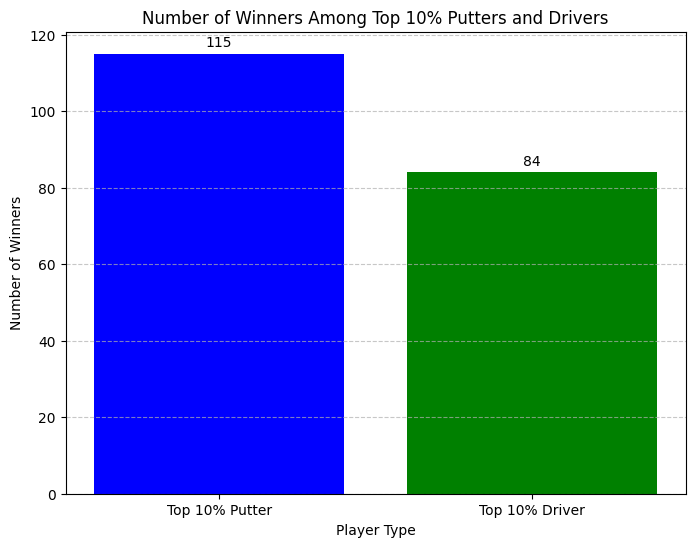

In [12]:
def insight6():
  # covariance, logically follows insight 2
  df = data_parser()
  df1 = df[['sg_ott', 'sg_putt']]
  print(df1)
  print(np.cov(np.array(df1).T))
  print(f"Pearson's Coefficient Data: {stats.pearsonr(df['sg_putt'], df['sg_ott'])}")
insight5()

###*Insight 6 & 7 Explanation*

One might expect that being a good driver will aritifically inflate one's putting statistics because being a good driver will set a golfer up in better putting posiitons. On the flip side, you could expect a better driver to be a worse putter because by training to be a better driver you forego the time needed to become a better putter - sort of like baseball pitchers traditionally being bad batters. We found that in our dataset, these two factors roughly cancel out, as the covariance between sg_ott and sg_putt is approximately 0 (-0.0285). Furthermore, the r^2 statistic for the correlation between the two is also nearly 0 (-0.03235). We also confirmed our observations in insight2 that the variance of sg_ott is significantly lower than that of sg_putt (0.6327 vs 1.2295).

We also visualize the relationship between sg_ott and sg_putt relative to cuts made and top 20 performances.

Which players get cut?


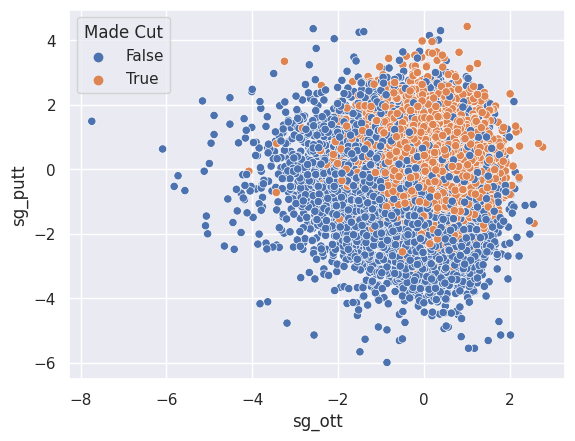

Which players finish top 20?


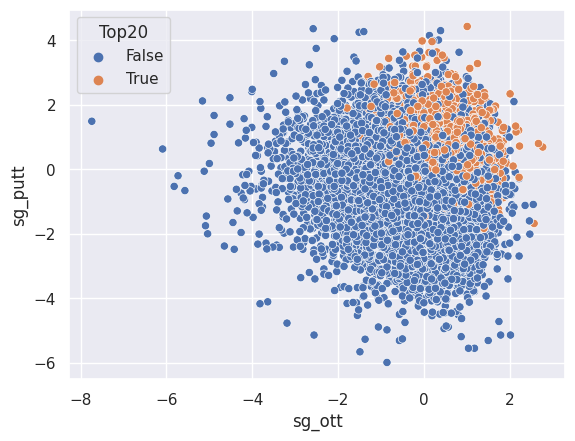

In [13]:
def insight7():
  # covariance, logically follows insight 2
  df = data_parser()
  boolCut = df['finish'] != 105
  df = pd.concat((df, boolCut), axis = 1)
  df.columns.values[-1] = "Made Cut"
  boolTop20 = df['finish'] <= 20
  df = pd.concat((df,boolTop20), axis = 1)
  df.columns.values[-1] = 'Top20'
  #print(df.head())

  # UNIQUE VISUALIZATION 4
  sns.set()
  cut = sns.scatterplot(x='sg_ott', y="sg_putt", hue='Made Cut', data=df)
  print('Which players get cut?')
  plt.show()

  sns.set()
  top = sns.scatterplot(x='sg_ott', y="sg_putt", hue='Top20', data=df)
  print('Which players finish top 20?')
  plt.show()

insight7()

## Summary Files

In [14]:
def summary1():
  """
  exports data containing golfers'
  1. standardized average driving distance,
  2. standardized average putts per round,
  3. total PGA Tour Championship points,
  4. and classification as a driver or putter
  to a CSV file.
  """
  df = insight4()
  df.to_csv('tourPoints_vs_driving_vs_putting.csv', index=False)

############ Function Call ############
summary1()

# Video Presentation

If you uploaded your Video Presentation to Bluejeans, YouTube, or any other streaming services, please provide the link here:


https://youtu.be/V0LuVmNcBY4

Video should be unlisted


# Submission

Prior to submitting your notebook to Gradescope, be sure to <b>run all functions within this file</b>. We will not run your functions ourselves, so we must see your outputs within this file in order to receive full credit.
